In [115]:
# Esqueleto de evaluación de BIC para el agrupamiento para cada variable climatológica
# BIC - Bayesian Information Criterion
# De esta manera vemos cual es número ideal de componentes y el mejor método para el agrupamiento
#
# Esto no se corre, ya fue corrido antes pero no tuve el cuidado de guardar esta información
# Sin embargo, el agrupamiento seleccionado para cada variable si es el que minimiza el BIC 
# H, full, 2 components
# D, full, 6 components
# B, tied, 5 components
# L, full, 11 components
Xbic=XprojL
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for kcomp in np.arange(25)+1:
        gmm = GMM(kcomp, covariance_type=cv_type, random_state=0)
        gmm.fit(Xbic)
#        print cv_type,kcomp,gmm.bic(Xbic)

In [1]:
from sklearn.decomposition import PCA
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GMM
import subprocess

In [2]:
# función para convertir los datos de LONLAT a formato legible por el computador
def conversion(old):
    direction = {'N':-1, 'S':1, 'E': -1, 'W':1} # diccionario
    new = old.replace('\xc2\xb0',' ').replace('\'',' ').replace('"',' ')
    new = new.split() # separa grados, minutos, segundos, orientación en una lista de 4 objetos
    new_dir = new.pop() # extrae la orientación
    return (int(new[0])+int(new[1])/60.0+int(float(new[2]))/3600.0) * direction[new_dir]

In [3]:
# mapa de Colombia
colvec=np.loadtxt('colvecdep.txt')

(445, 2)
0.959021220933
[ 0.84050377  0.11851745]
6908.59204417
Number of stations in cluster 0 is 258
Number of stations in cluster 1 is 187


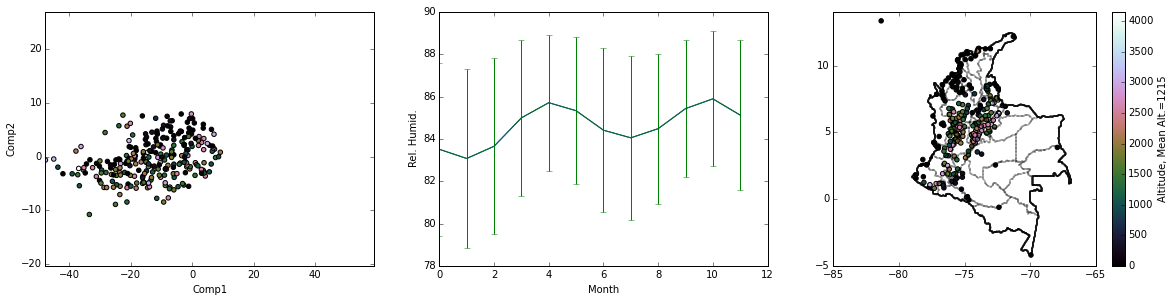

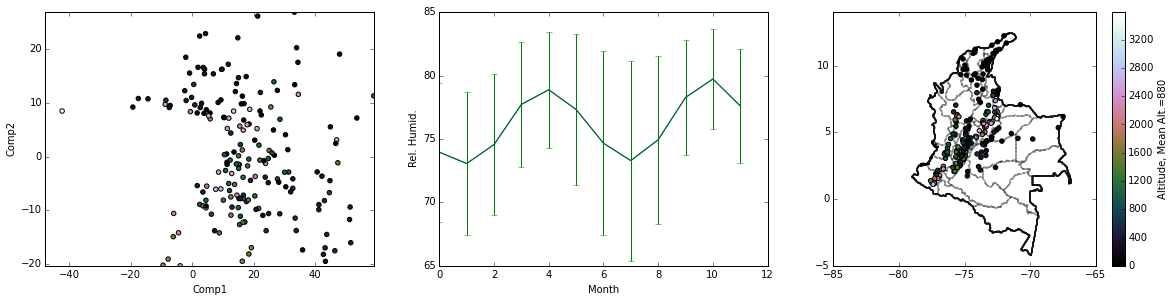

In [4]:
# Para humedad, el PCA cubre >95% de varianza
df=pd.read_csv('humedad.csv')

AH=df.as_matrix(columns=df.columns[8:20])
pca = PCA(2)  
XprojH = pca.fit_transform(AH)
print(XprojH.shape)
print pca.explained_variance_ratio_.sum(axis=0)
print pca.explained_variance_ratio_

# para que las gráficas se vean con los mismos ejes
xmin=min(XprojH[:, 0])
xmax=max(XprojH[:, 0])
ymin=min(XprojH[:, 1])
ymax=max(XprojH[:, 1])

# conversión de formato LATLON
latH=np.zeros(len(df.LATITUD))
lonH=np.zeros(len(df.LATITUD))
codeH=np.zeros(len(df.LATITUD))
altH=np.zeros(len(df.LATITUD))
for i in range(len(df.LATITUD)):
    latH[i]=conversion(df.LATITUD[i])
    lonH[i]=conversion(df.LONGITUD[i])
    codeH[i]=df.CODIGO[i]
    altH[i]=df.ELEV[i]
    
# Mixtura gaussiana para kcomp clusters
kcomp=2
gmm = GMM(kcomp, covariance_type='full', random_state=0)
gmm.fit(XprojH)
print gmm.bic(XprojH)
cluster_labelH = gmm.predict(XprojH)


# Se hace una gráfica para cada cluster
for kk in range(kcomp):
    D=np.zeros([sum(cluster_labelH==kk),2])
    B=np.zeros([sum(cluster_labelH==kk),12])
    LAT=np.zeros([sum(cluster_labelH==kk)])
    LON=np.zeros([sum(cluster_labelH==kk)])
    ALTH=np.zeros([sum(cluster_labelH==kk)])
    i=0
    for k in range(len(cluster_labelH)):
        if cluster_labelH[k]==kk:
            B[i]=AH[k]
            D[i]=XprojH[k]
            LAT[i]=latH[k]
            LON[i]=lonH[k]
            ALTH[i]=df.ELEV[k]
            i=i+1
    print "Number of stations in cluster %i is %i" %(kk,i)
    plt.figure(figsize=(20,5*kcomp))
    ii=0

#
    plt.subplot(kcomp, 3, ii+1)
    plt.scatter(D[:, 0], D[:, 1],c=ALTH,cmap='cubehelix')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('Comp1')
    plt.ylabel('Comp2')

    xx=np.arange(12)
    plt.subplot(kcomp, 3, ii+2)
    plt.plot(B.mean(axis=0))
    plt.errorbar(xx,B.mean(axis=0),yerr=B.std(axis=0))
    plt.xlabel('Month')
    plt.ylabel('Rel. Humid.')

    plt.subplot(kcomp, 3, ii+3)
    plt.scatter(-LON,-LAT,c=ALTH,cmap='cubehelix')
    plt.colorbar(label='Altitude, Mean Alt.=%i' % ALTH.mean())
    plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
    plt.xlim(-85,-65)
    plt.ylim(-5,14)
    ii=ii+3

38


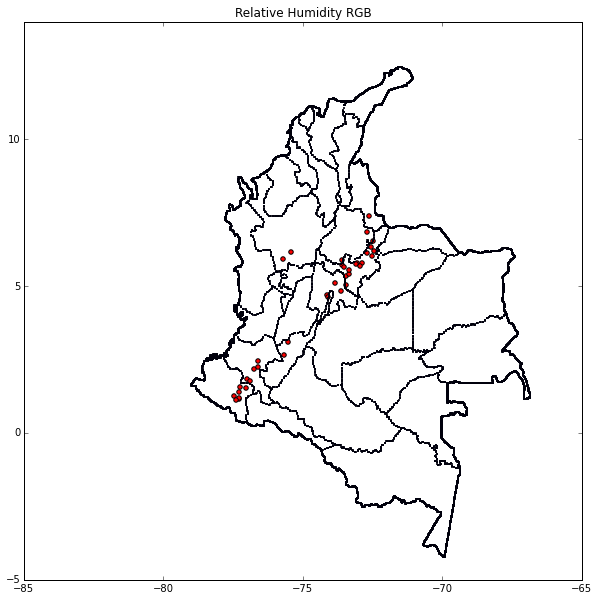

In [5]:
# Esto es para graficarlos todos en una misma gráfica de LATLON. Ahora LAT y LON son arrays
LATH=np.zeros([len(cluster_labelH),kcomp])
LONH=np.zeros([len(cluster_labelH),kcomp])
ALTH=np.zeros([len(cluster_labelH),kcomp])
CODH=np.zeros([len(cluster_labelH),kcomp])
for kk in range(kcomp):
    i=0
    for k in range(len(df)):
        if cluster_labelH[k]==kk:
            LATH[i,kk]=latH[k]
            LONH[i,kk]=lonH[k]
            ALTH[i,kk]=df.ELEV[k]
            CODH[i,kk]=df.CODIGO[k]
            i=i+1
# Los puntos rojos son el segundo cluster, el más interesante para nosotros
# Los siguientes importantes son los verdes (cuarto cluster)
plt.figure(figsize=(10,10))
filter1=ALTH[:,1]>1500
filter0=ALTH[:,0]>1500
plt.scatter(-LONH[:,1][filter1],-LATH[:,1][filter1],c='r')
plt.scatter(colvec[:,0],colvec[:,1],s=1)
#plt.scatter(-LONH[:,0][filter0],-LATH[:,0][filter0],c='g')
plt.xlim(-85,-65)
plt.ylim(-5,14)
plt.title("Relative Humidity RGB")
print filter1.sum()

(2046, 12)
(2046, 3)
0.959578491041
[ 0.78211583  0.13516064  0.04230202]
Number of stations in cluster 0 is 67
Number of stations in cluster 1 is 194
Number of stations in cluster 2 is 269
Number of stations in cluster 3 is 114
Number of stations in cluster 4 is 244
Number of stations in cluster 5 is 295
Number of stations in cluster 6 is 185
Number of stations in cluster 7 is 3
Number of stations in cluster 8 is 176
Number of stations in cluster 9 is 56
Number of stations in cluster 10 is 443


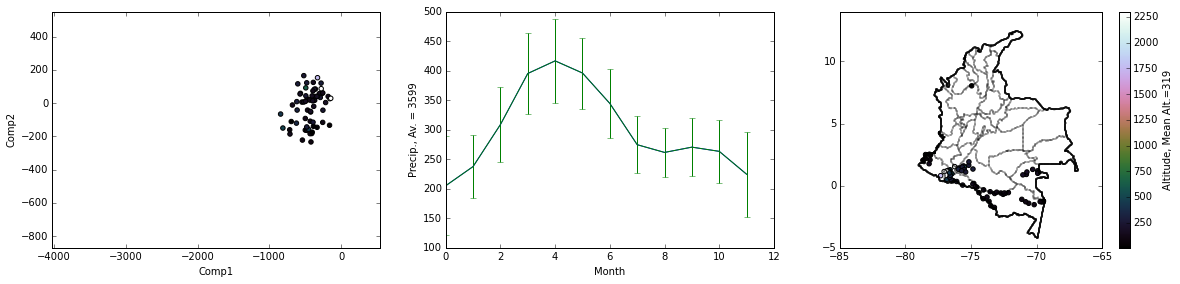

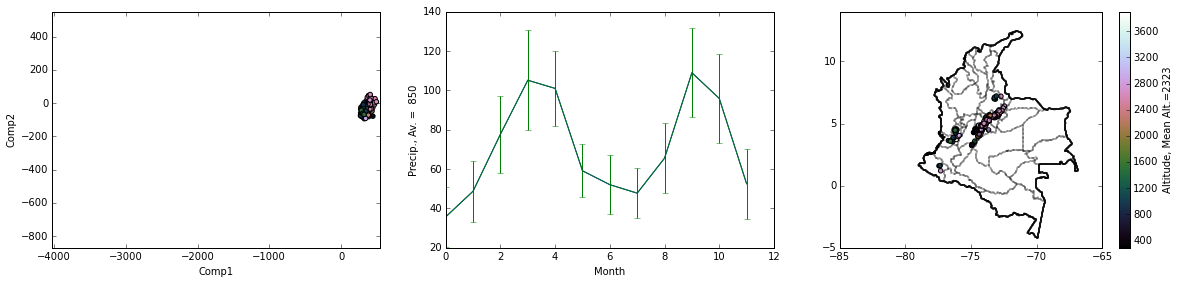

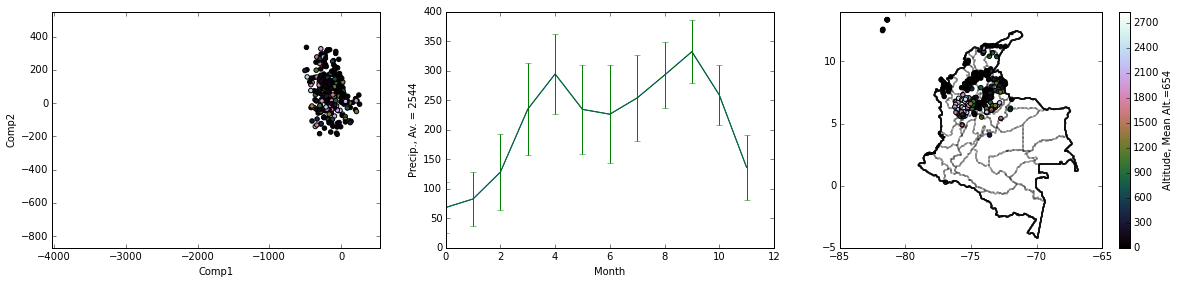

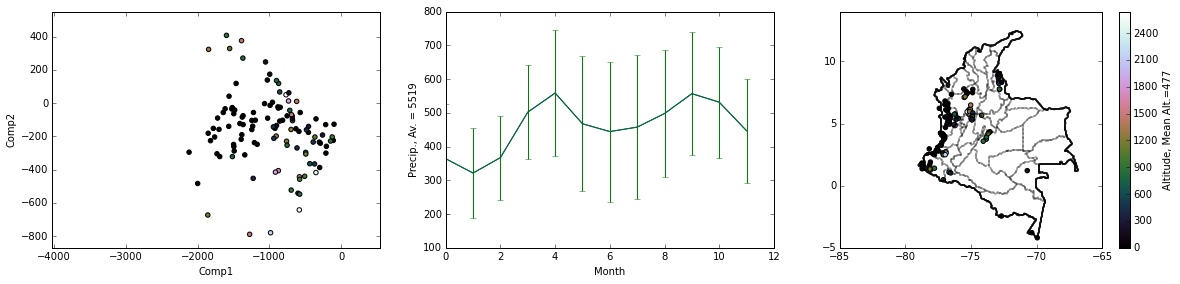

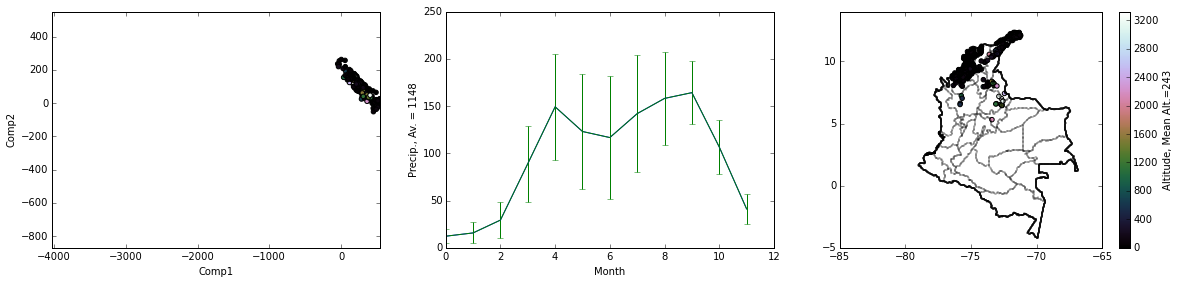

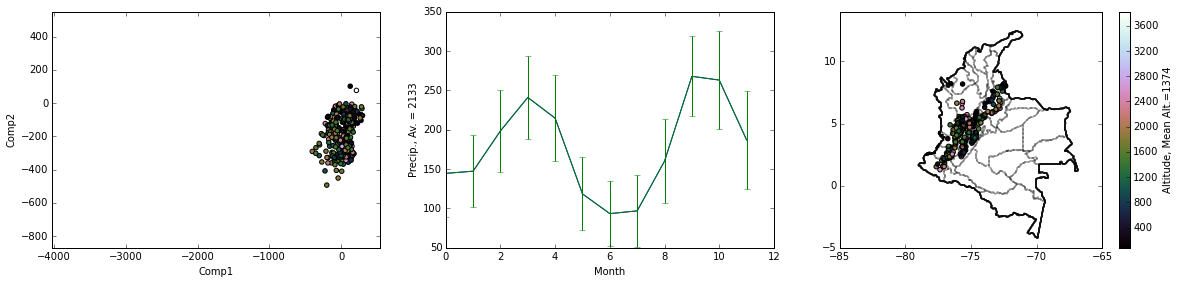

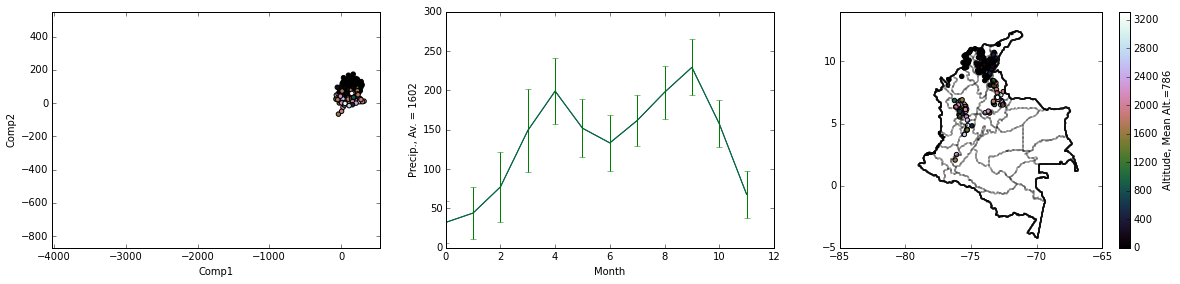

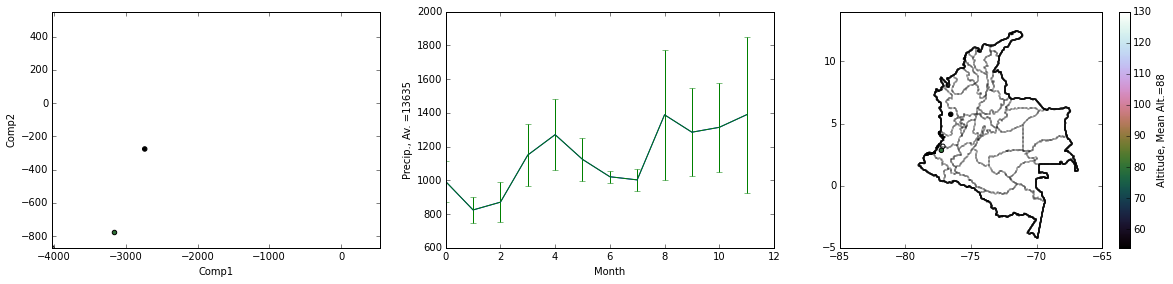

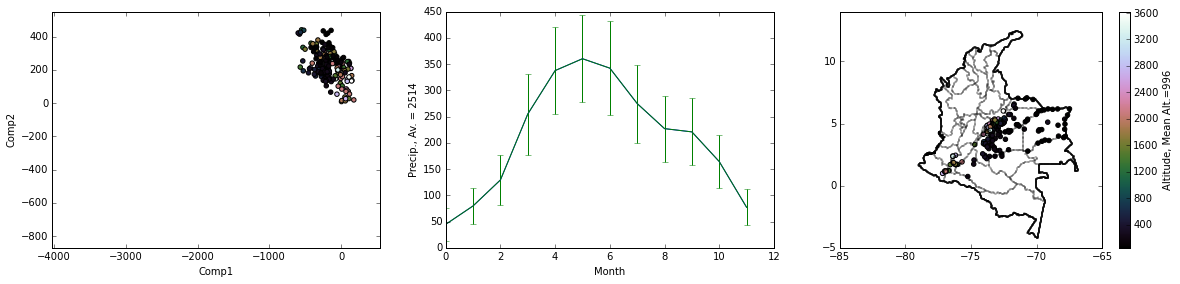

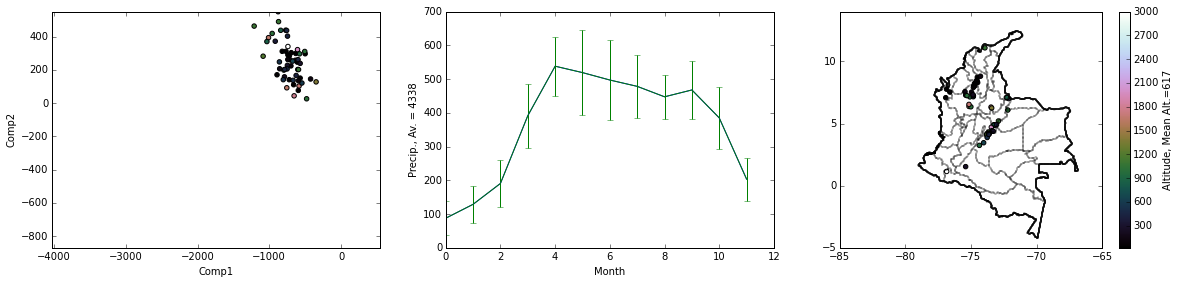

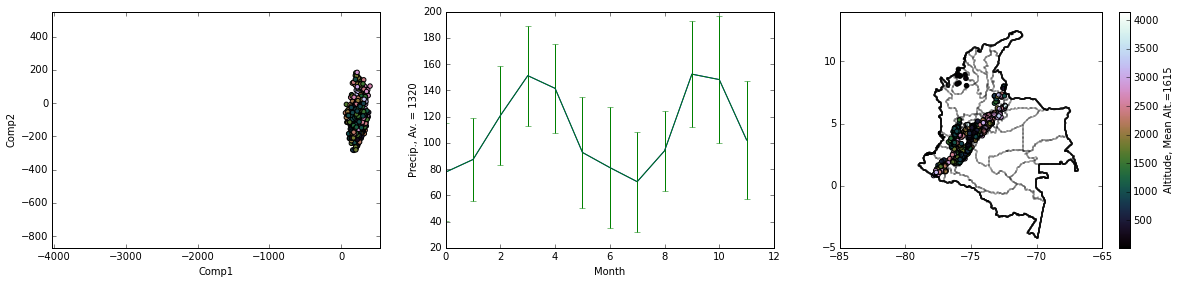

In [6]:
# ahora con lluvia, se requieren 3 componentes para cubrir >95% de varianza
df=pd.read_csv('lluvia.csv')
df.head()

# script que hace todo lo anterior, pero con lluvia, usando lluvia.csv

# Componentes principales
AL=df.as_matrix(columns=df.columns[8:20])
pca = PCA(0.95)  
XprojL = pca.fit_transform(AL)
print(AL.shape)
print(XprojL.shape)
print pca.explained_variance_ratio_.sum(axis=0)
print pca.explained_variance_ratio_
Ncomp = XprojL.shape[1]

# para que las gráficas se vean con los mismos ejes
xmin=min(XprojL[:, 0])
xmax=max(XprojL[:, 0])
ymin=min(XprojL[:, 1])
ymax=max(XprojL[:, 1])

# conversión de formato LATLON
latL=np.zeros(len(df.LATITUD))
lonL=np.zeros(len(df.LATITUD))
codeL=np.zeros(len(df.LATITUD))
altL=np.zeros(len(df.LATITUD))
for i in range(len(df.LATITUD)):
    latL[i]=conversion(df.LATITUD[i])
    lonL[i]=conversion(df.LONGITUD[i])
    codeL[i]=df.CODIGO[i]
    altL[i]=df.ELEV[i]
    
# Mixtura gaussiana para kcomp clusters (4)
kcomp=11
gmm = GMM(kcomp, covariance_type='full', random_state=0)
gmm.fit(XprojL)
cluster_labelL = gmm.predict(XprojL)


# Se hace una gráfica para cada cluster
for kk in range(kcomp):
    D=np.zeros([sum(cluster_labelL==kk),Ncomp])
    B=np.zeros([sum(cluster_labelL==kk),12])
    LAT=np.zeros([sum(cluster_labelL==kk)])
    LON=np.zeros([sum(cluster_labelL==kk)])
    ALTL=np.zeros([sum(cluster_labelL==kk)])
    i=0
    for k in range(len(df)):
        if cluster_labelL[k]==kk:
            B[i]=AL[k]
            D[i]=XprojL[k]
            LAT[i]=latL[k]
            LON[i]=lonL[k]
            ALTL[i]=df.ELEV[k]
            i=i+1
    print "Number of stations in cluster %i is %i" %(kk,i)
    plt.figure(figsize=(20,5*kcomp))
    ii=0

#
    plt.subplot(kcomp, 3, ii+1)
    plt.scatter(D[:, 0], D[:, 1],c=ALTL,cmap='cubehelix')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('Comp1')
    plt.ylabel('Comp2')

    xx=np.arange(12)
    plt.subplot(kcomp, 3, ii+2)
    plt.plot(B.mean(axis=0))
    plt.errorbar(xx,B.mean(axis=0),yerr=B.std(axis=0))
    plt.xlabel('Month')
    plt.ylabel('Precip., Av. =%5.f' % B.mean(axis=0).sum())

    plt.subplot(kcomp, 3, ii+3)
    plt.scatter(-LON,-LAT,c=ALTL,cmap='cubehelix')
    plt.colorbar(label='Altitude, Mean Alt.=%i' % ALTL.mean())
    plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
    plt.xlim(-85,-65)
    plt.ylim(-5,14)
    ii=ii+3
    

445


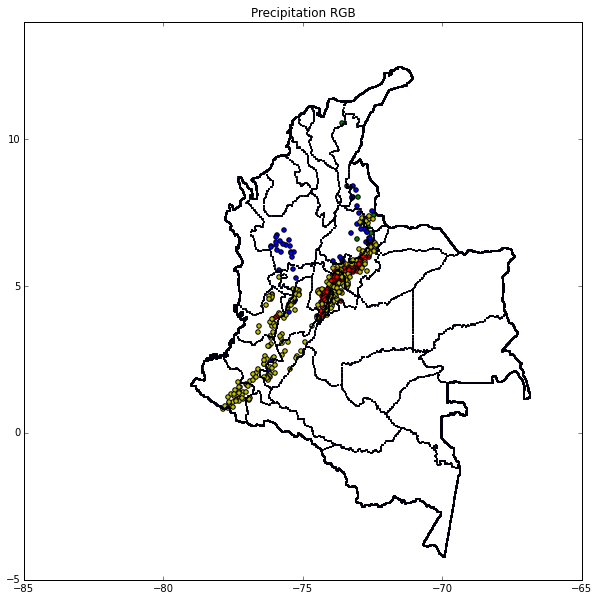

In [7]:
# Esto es para graficarlos todos en una misma gráfica de LATLON. Ahora LAT y LON son arrays
LATL=np.zeros([len(cluster_labelL),kcomp])
LONL=np.zeros([len(cluster_labelL),kcomp])
ALTL=np.zeros([len(cluster_labelL),kcomp])
CODL=np.zeros([len(cluster_labelL),kcomp])
for kk in range(kcomp):
    i=0
    for k in range(len(df)):
        if cluster_labelL[k]==kk:
            LATL[i,kk]=latL[k]
            LONL[i,kk]=lonL[k]
            ALTL[i,kk]=df.ELEV[k]
            CODL[i,kk]=df.CODIGO[k]
            i=i+1
# Graficamos 3 componentes al tiempo. Los puntos rojos son el primer cluster, el más interesante para nosotros
# Los siguientes importantes son el segundo cluster (verdes)
plt.figure(figsize=(10,10))
filter1=ALTL[:,1]>1500
filter4=ALTL[:,4]>1500
filter6=ALTL[:,6]>1500
filter10=ALTL[:,10]>1500
plt.scatter(-LONL[:,1][filter1],-LATL[:,1][filter1],c='r')
plt.scatter(-LONL[:,4][filter4],-LATL[:,4][filter4],c='g')
plt.scatter(-LONL[:,6][filter6],-LATL[:,6][filter6],c='b')
plt.scatter(-LONL[:,10][filter10],-LATL[:,10][filter10],c='y')
plt.scatter(colvec[:,0],colvec[:,1],s=1)

# Esta no porque pa que
#plt.scatter(-LON[:,3],-LAT[:,3],c='y')
plt.xlim(-85,-65)
plt.ylim(-5,14)
plt.title("Precipitation RGB")
print filter1.sum()+filter4.sum()+filter6.sum()+filter10.sum()

(2002, 12)
(2002, 3)
0.963298585519
[ 0.77041413  0.16628419  0.02660027]
Number of stations in cluster 0 is 359
Number of stations in cluster 1 is 244
Number of stations in cluster 2 is 444
Number of stations in cluster 3 is 348
Number of stations in cluster 4 is 278
Number of stations in cluster 5 is 329


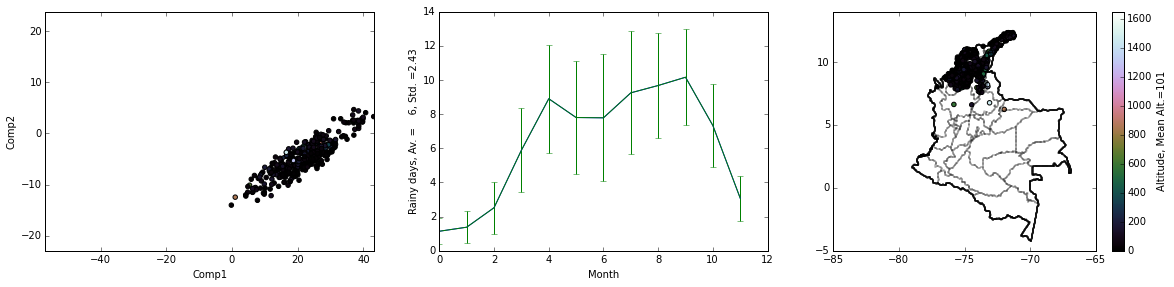

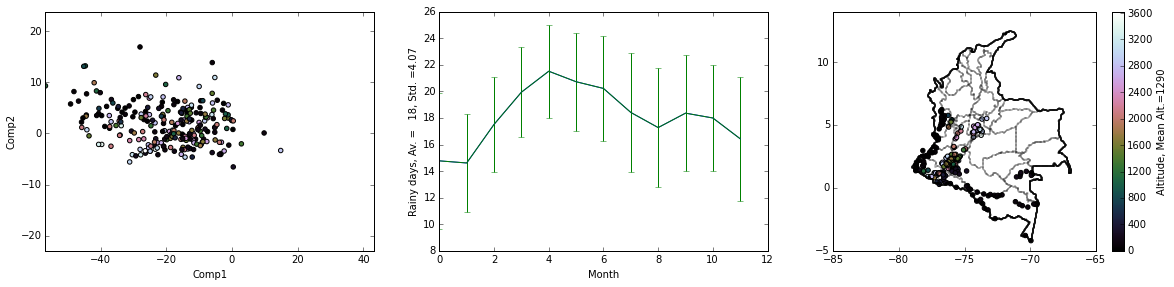

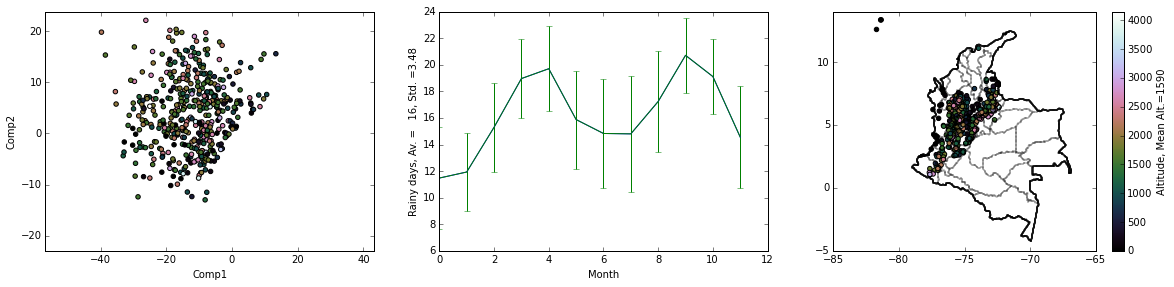

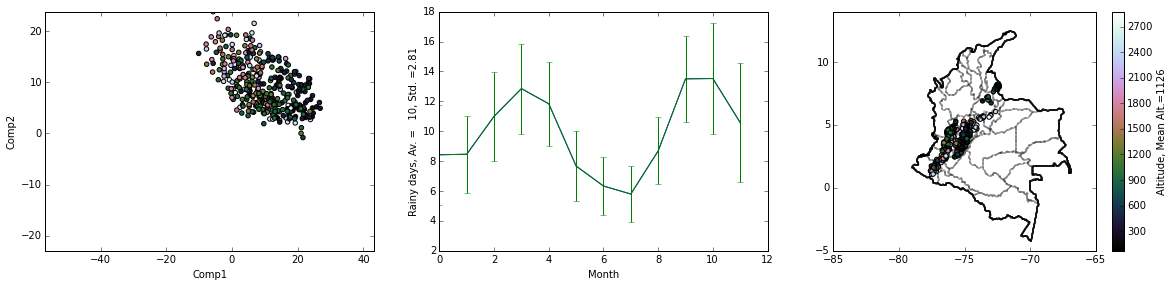

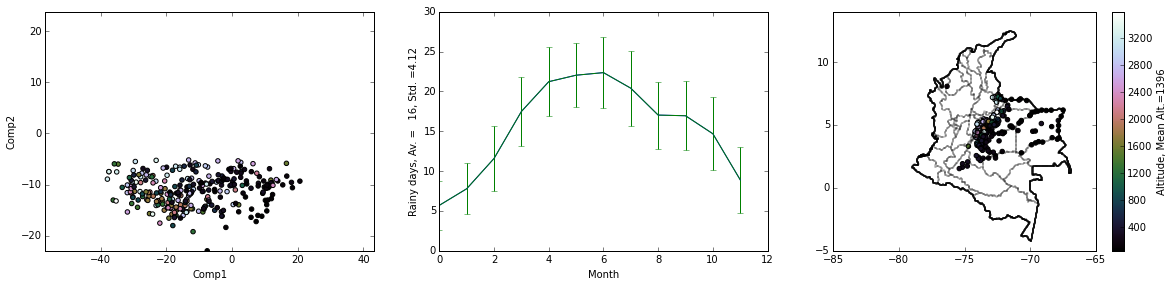

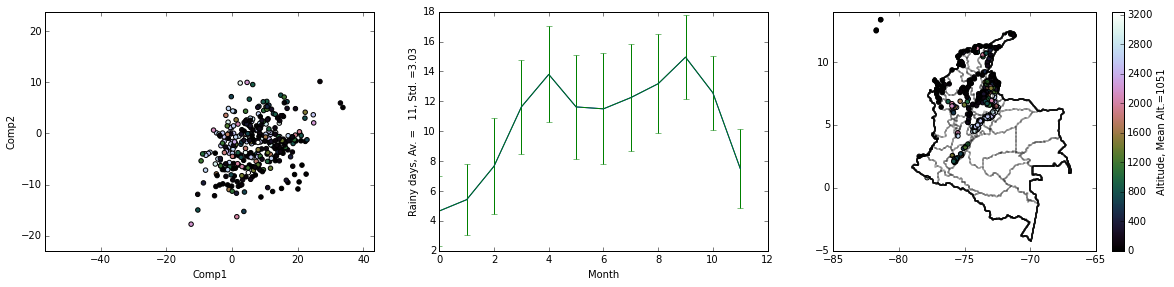

In [8]:
# ahora con días con lluvia, también toca con tres componentes
df=pd.read_csv('diaslluvia.csv')

#datos crudos mes a mes por estacion - días con lluvia de diaslluvia.csv
#AB=AD[np.isfinite(AD).prod(axis=1).astype(bool),:]
AD=df.as_matrix(columns=df.columns[8:20])
pca = PCA(0.95)  
XprojD = pca.fit_transform(AD)
print(AD.shape)
print(XprojD.shape)
print pca.explained_variance_ratio_.sum(axis=0)
print pca.explained_variance_ratio_
Ncomp = XprojD.shape[1]

# para que las gráficas se vean con los mismos ejes
xmin=min(XprojD[:, 0])
xmax=max(XprojD[:, 0])
ymin=min(XprojD[:, 1])
ymax=max(XprojD[:, 1])

# conversión de formato LATLON
latD=np.zeros(len(df.LATITUD))
lonD=np.zeros(len(df.LATITUD))
codeD=np.zeros(len(df.LATITUD))
altD=np.zeros(len(df.LATITUD))
for i in range(len(df.LATITUD)):
    latD[i]=conversion(df.LATITUD[i])
    lonD[i]=conversion(df.LONGITUD[i])
    codeD[i]=df.CODIGO[i]    
    altD[i]=df.ELEV[i]
# Mixtura gaussiana para kcomp clusters
kcomp=6
gmm = GMM(kcomp, covariance_type='full', random_state=0)
gmm.fit(XprojD)
cluster_labelD = gmm.predict(XprojD)
#df['Cluster1'] = cluster_label

# Se hace una gráfica para cada cluster
for kk in range(kcomp):
    D=np.zeros([sum(cluster_labelD==kk),Ncomp])
    B=np.zeros([sum(cluster_labelD==kk),12])
    LAT=np.zeros([sum(cluster_labelD==kk)])
    LON=np.zeros([sum(cluster_labelD==kk)])
    ALT=np.zeros([sum(cluster_labelD==kk)])
    i=0
    for k in range(len(cluster_labelD)):
        if cluster_labelD[k]==kk:
            B[i]=AD[k]
            D[i]=XprojD[k]
            LAT[i]=latD[k]
            LON[i]=lonD[k]
            ALT[i]=df.ELEV[k]
            i=i+1
    print "Number of stations in cluster %i is %i" %(kk,i)
    plt.figure(figsize=(20,5*kcomp))
    ii=0

#
    plt.subplot(kcomp, 3, ii+1)
    plt.scatter(D[:, 0], D[:, 1],c=ALT,cmap='cubehelix')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('Comp1')
    plt.ylabel('Comp2')

    xx=np.arange(12)
    plt.subplot(kcomp, 3, ii+2)
    plt.plot(B.mean(axis=0))
    plt.errorbar(xx,B.mean(axis=0),yerr=B.std(axis=0))
    plt.xlabel('Month')
    plt.ylabel('Rainy days, Av. =%5.f, Std. =%2.2f' % (B.mean(axis=0).mean(),B.std(axis=0).mean())  )

    plt.subplot(kcomp, 3, ii+3)
    plt.scatter(-LON,-LAT,c=ALT,cmap='cubehelix')
    plt.colorbar(label='Altitude, Mean Alt.=%i' % ALT.mean())
    plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
    plt.xlim(-85,-65)
    plt.ylim(-5,14)
    ii=ii+3
    

199


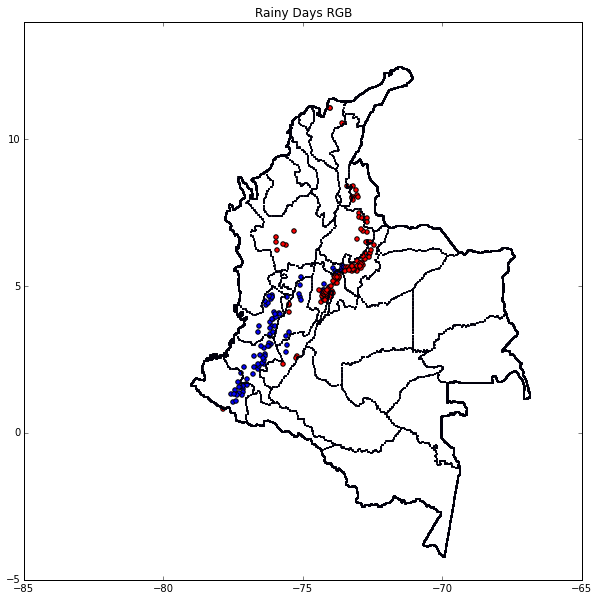

In [9]:
# Esto es para graficarlos todos en una misma gráfica de LATLON. Ahora LAT y LON son arrays
LATD=np.zeros([len(cluster_labelD),kcomp])
LOND=np.zeros([len(cluster_labelD),kcomp])
ALTD=np.zeros([len(cluster_labelD),kcomp])
CODD=np.zeros([len(cluster_labelD),kcomp])

for kk in range(kcomp):
    i=0
    for k in range(len(cluster_labelD)):
        if cluster_labelD[k]==kk:
            LATD[i,kk]=latD[k]
            LOND[i,kk]=lonD[k]
            ALTD[i,kk]=df.ELEV[k]
            CODD[i,kk]=df.CODIGO[k]
            i=i+1
# Graficamos 3 componentes al tiempo. Los puntos rojos son el primer cluster, el más interesante para nosotros
# El tercero también es interesante
# Lo otro que falta es hacer un clustering por LONLAT y altura sobre las estaciones que tengan las condiciones ideales
plt.figure(figsize=(10,10))

filter0=ALTD[:,0]>1500
filter3=ALTD[:,3]>1500
filter5=ALTD[:,5]>1500
plt.scatter(-LOND[:,0][filter0],-LATD[:,0][filter0],c='g')
plt.scatter(-LOND[:,3][filter3],-LATD[:,3][filter3],c='b')
plt.scatter(-LOND[:,5][filter5],-LATD[:,5][filter5],c='r')
plt.scatter(colvec[:,0],colvec[:,1],s=1)

# Esta no porque pa que
#plt.scatter(-LON[:,3],-LAT[:,3],c='y')
plt.xlim(-85,-65)
plt.ylim(-5,14)
plt.title('Rainy Days RGB')
# Hay que cambiar el orden, primero es 2, segundo es 0
print filter0.sum()+filter3.sum()+filter5.sum()

(336, 12)
(336, 3)
0.968881031972
[ 0.8163693   0.11928973  0.03322201]
3982.44755121
Number of stations in cluster 0 is 121
Number of stations in cluster 1 is 46
Number of stations in cluster 2 is 63
Number of stations in cluster 3 is 43
Number of stations in cluster 4 is 63


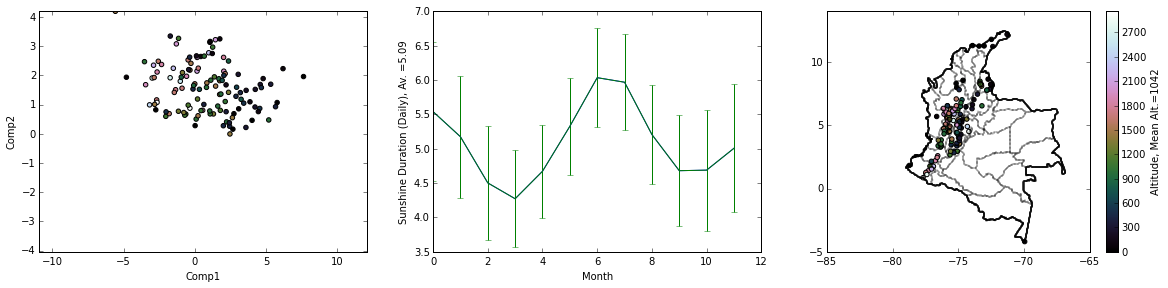

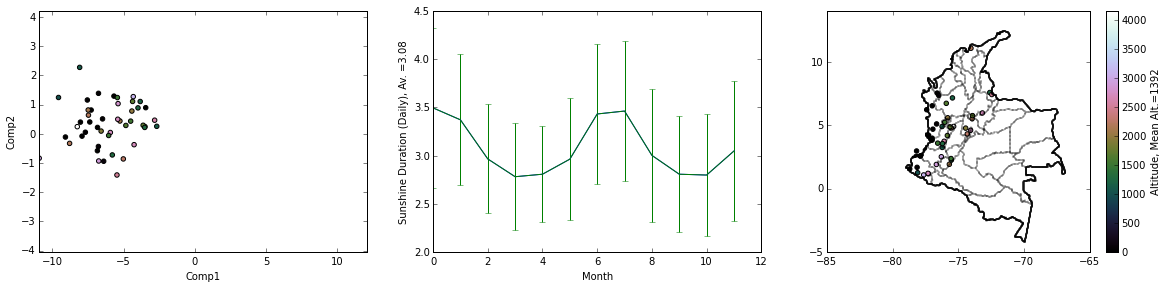

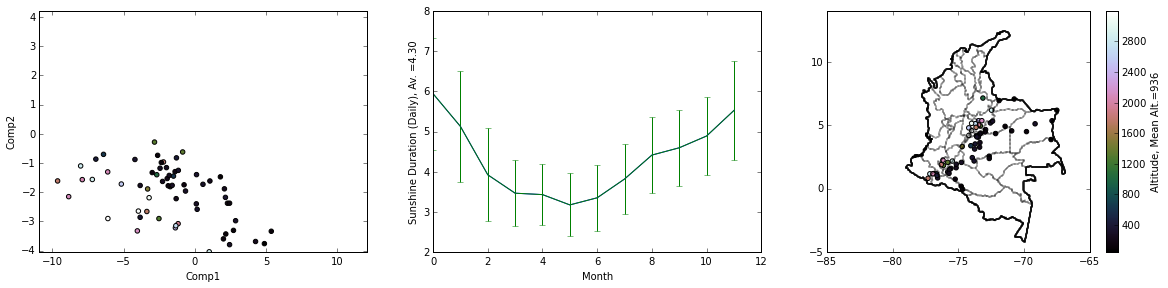

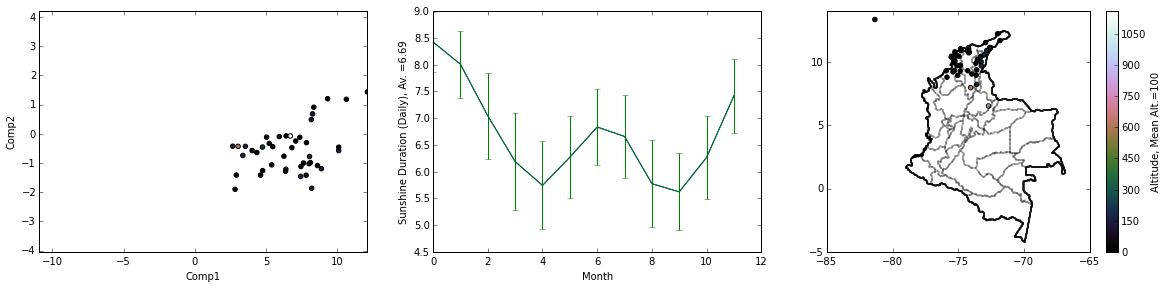

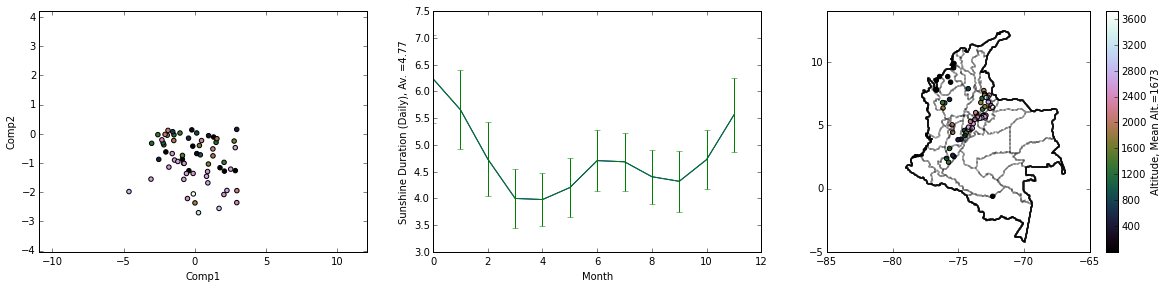

In [10]:
# ahora con brillo solar
df=pd.read_csv('brillo.csv')

#datos crudos mes a mes por estacion - brillo solar de brillo.csv
AB=df.as_matrix(columns=df.columns[8:20])
pca = PCA(0.95)  
XprojB = pca.fit_transform(AB)
print(AB.shape)
print(XprojB.shape)
print pca.explained_variance_ratio_.sum(axis=0)
print pca.explained_variance_ratio_
Ncomp = XprojB.shape[1]


# para que las gráficas se vean con los mismos ejes
xmin=min(XprojB[:, 0])
xmax=max(XprojB[:, 0])
ymin=min(XprojB[:, 1])
ymax=max(XprojB[:, 1])

# conversión de formato LATLON
latB=np.zeros(len(df.LATITUD))
lonB=np.zeros(len(df.LATITUD))
codeB=np.zeros(len(df.LATITUD))
altB=np.zeros(len(df.LATITUD))
for i in range(len(df.LATITUD)):
    latB[i]=conversion(df.LATITUD[i])
    lonB[i]=conversion(df.LONGITUD[i])
    codeB[i]=df.CODIGO[i]    
    altB[i]=df.ELEV[i]
# Mixtura gaussiana para kcomp clusters
kcomp=5
gmm = GMM(kcomp, covariance_type='tied', random_state=0)
gmm.fit(XprojB)
print gmm.bic(XprojB)
cluster_labelB = gmm.predict(XprojB)

# Se hace una gráfica para cada cluster
for kk in range(kcomp):
    D=np.zeros([sum(cluster_labelB==kk),Ncomp])
    B=np.zeros([sum(cluster_labelB==kk),12])
    LAT=np.zeros([sum(cluster_labelB==kk)])
    LON=np.zeros([sum(cluster_labelB==kk)])
    ALT=np.zeros([sum(cluster_labelB==kk)])
    i=0
    for k in range(len(cluster_labelB)):
        if cluster_labelB[k]==kk:
            B[i]=AB[k]
            D[i]=XprojB[k]
            LAT[i]=latB[k]
            LON[i]=lonB[k]
            ALT[i]=df.ELEV[k]
            i=i+1
    print "Number of stations in cluster %i is %i" %(kk,i)
    plt.figure(figsize=(20,5*kcomp))
    ii=0

#
    plt.subplot(kcomp, 3, ii+1)
    plt.scatter(D[:, 0], D[:, 1],c=ALT,cmap='cubehelix')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('Comp1')
    plt.ylabel('Comp2')

    xx=np.arange(12)
    plt.subplot(kcomp, 3, ii+2)
    plt.plot(B.mean(axis=0))
    plt.errorbar(xx,B.mean(axis=0),yerr=B.std(axis=0))
    plt.xlabel('Month')
    plt.ylabel('Sunshine Duration (Daily), Av. =%.2f' % B.mean(axis=0).mean())

    plt.subplot(kcomp, 3, ii+3)
    plt.scatter(-LON,-LAT,c=ALT,cmap='cubehelix')
    plt.colorbar(label='Altitude, Mean Alt.=%i' % ALT.mean())
    plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
    plt.xlim(-85,-65)
    plt.ylim(-5,14)
    ii=ii+3
    

69


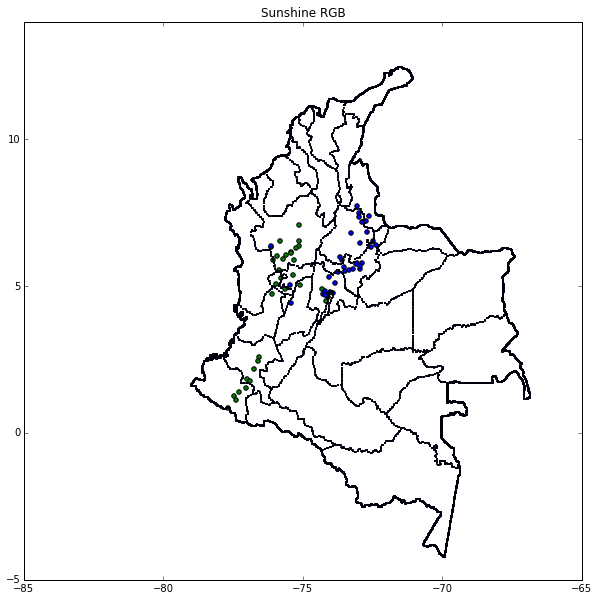

In [11]:
# Esto es para graficarlos todos en una misma gráfica de LATLON. Ahora LAT y LON son arrays
LATB=np.zeros([len(cluster_labelB),kcomp])
LONB=np.zeros([len(cluster_labelB),kcomp])
ALTB=np.zeros([len(cluster_labelB),kcomp])
CODB=np.zeros([len(cluster_labelB),kcomp])
for kk in range(kcomp):
    i=0
    for k in range(len(cluster_labelB)):
        if cluster_labelB[k]==kk:
            LATB[i,kk]=latB[k]
            LONB[i,kk]=lonB[k]
            ALTB[i,kk]=df.ELEV[k]
            CODB[i,kk]=df.CODIGO[k]
            i=i+1
# Graficamos 3 componentes al tiempo. Los puntos rojos son el segundo cluster, el más interesante para nosotros
# El cuarto también es interesante
# Lo otro que falta es hacer un clustering por LONLAT y altura sobre las estaciones que tengan las condiciones ideales
plt.figure(figsize=(10,10))
filter3=ALTB[:,3]>1500
filter4=ALTB[:,4]>1500

filter0=ALTB[:,0]>1500
plt.scatter(-LONB[:,0][filter0],-LATB[:,0][filter0],c='g')
#plt.scatter(-LONB[:,1],-LATB[:,1],c='y')
#plt.scatter(-LONB[:,3],-LATB[:,3],c='b')
# Esta no porque pa que
plt.scatter(-LONB[:,3][filter3],-LATB[:,3][filter3],c='r')
plt.scatter(-LONB[:,4][filter4],-LATB[:,4][filter4],c='b')
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-85,-65)
plt.ylim(-5,14)
plt.title('Sunshine RGB')
# principal: 2 secundario 0
print filter0.sum()+filter3.sum()+filter4.sum()

(-5, 14)

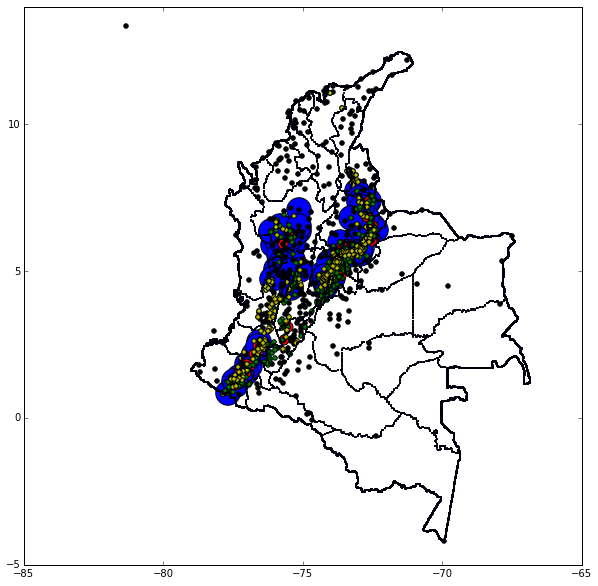

In [12]:
#Aplicamos el filtro de altura > 1500 msnm para cada grupo de interes para cada variable

plt.figure(figsize=(10,10))
filter3=ALTB[:,3]>1500
filter4=ALTB[:,4]>1500
filter0=ALTB[:,0]>1500
plt.scatter(-LONB[:,0][filter0],-LATB[:,0][filter0],c='b',s=600)
plt.scatter(-LONB[:,3][filter3],-LATB[:,3][filter3],c='b',s=600)
plt.scatter(-LONB[:,4][filter4],-LATB[:,4][filter4],c='b',s=600)

filter1=ALTH[:,1]>1500
plt.scatter(-LONH[:,1][filter1],-LATH[:,1][filter1],c='r',s=100)
plt.scatter(-LONH[:,1],-LATH[:,1],c='k')
plt.scatter(-LONH[:,0],-LATH[:,0],c='k')

filter1=ALTL[:,1]>1500
filter4=ALTL[:,4]>1500
filter6=ALTL[:,6]>1500
filter10=ALTL[:,10]>1500
plt.scatter(-LONL[:,1][filter1],-LATL[:,1][filter1],c='g')
plt.scatter(-LONL[:,4][filter4],-LATL[:,4][filter4],c='g')
plt.scatter(-LONL[:,6][filter6],-LATL[:,6][filter6],c='g')
plt.scatter(-LONL[:,10][filter10],-LATL[:,10][filter10],c='g')

filter0=ALTD[:,0]>1500
filter3=ALTD[:,3]>1500
filter5=ALTD[:,5]>1500
plt.scatter(-LOND[:,0][filter0],-LATD[:,0][filter0],c='y')
plt.scatter(-LOND[:,3][filter3],-LATD[:,3][filter3],c='y')
plt.scatter(-LOND[:,5][filter5],-LATD[:,5][filter5],c='y')
plt.scatter(colvec[:,0],colvec[:,1],s=1)


plt.xlim(-85,-65)
plt.ylim(-5,14)

In [13]:
# Se unen todos los datos (los iniciales) de lonlat (hay repetidos)
CodT=np.hstack((codeB,codeH,codeL,codeD))
LonT=np.hstack((lonB,lonH,lonL,lonD))
LatT=np.hstack((latB,latH,latL,latD))
AltT=np.hstack((altB,altH,altL,altD))
np.savetxt('estaciones.txt',np.c_[CodT,LonT,LatT,AltT])
# después eliminamos repetidos y contamos cuantas variables mide cada estacion
proc = subprocess.Popen(["sort estaciones.txt | uniq -c > estaciones_medidas.txt"], stdout=subprocess.PIPE, shell=True)
proc = subprocess.Popen(["rm estaciones.txt"], stdout=subprocess.PIPE, shell=True)
proc = subprocess.Popen(["ls"], stdout=subprocess.PIPE, shell=True)
# 0=numero de variables medidas, 1=codigo de la estacion, 2,3=lonlat
EST=np.loadtxt('estaciones_medidas.txt')
stdout = proc.communicate()[0]
stdout.replace("\n"," ")

'bootstrap_snippets.ipynb brillo.csv colvecdep.txt diaslluvia.csv estaciones_medidas.txt humedad.csv listam.txt listatodos.txt listcompsc.txt listcomp.txt lluvia.csv PCA-IDEAM-WC.ipynb README.md '

In [14]:
# funcion que une los grupos de interes para cada variable, segun la clasificacion del modelo de mixtura gaussiana
# genera un arreglo con los datos "extraidos", p.ej. de todos los datos de precipitacion saco solo los que me interesan
# PP es una lista con los grupos que me interesan para cada variable
def stitch(PP,ALT,LON,LAT,COD,altfilt):
    LN=np.array([])
    LT=np.array([])
    CD=np.array([])
    AT=np.array([])
    for i in PP:
        filter=ALT[:,i]>altfilt
        LN=np.hstack((LN,LON[:,i][(LON[:,i]!=0)*(filter)]))
        LT=np.hstack((LT,LAT[:,i][(LAT[:,i]!=0)*(filter)]))
        CD=np.hstack((CD,COD[:,i][(COD[:,i]!=0)*(filter)]))
        AT=np.hstack((AT,ALT[:,i][(ALT[:,i]!=0)*(filter)]))
    return np.vstack((CD,LN,LT,AT)).T

In [16]:
# Generamos otra lista con todas las estaciones que cumplen al menos un criterio
# Aqui usamos la funcion anterior, PP le indica a la funcion cuales grupos me interesan
altfilt=-1.
PP=[0,3,4]
DATBT=stitch(PP,ALTB,LONB,LATB,CODB,altfilt)
PP=[1]
DATHT=stitch(PP,ALTH,LONH,LATH,CODH,altfilt)
PP=[1,4,6,10]
DATLT=stitch(PP,ALTL,LONL,LATL,CODL,altfilt)
PP=[0,3,5]
DATDT=stitch(PP,ALTD,LOND,LATD,CODD,altfilt)
# Se unen todas las variables en un solo arreglo, nos quedamos con 751 datos (hay repetidos)
# En este arreglo estan todos los datos que cumplen por lo menos uno de los criterios, y quedan a mas de 1500 msnm
# 0=codigo, 1,2=lonlat, 3=altura (segun la funcion stitch)
DATT_T=np.vstack((DATBT,DATHT,DATLT,DATDT))
np.savetxt('datostodos.txt',DATT_T)
# Luego unificamos con las estaciones que cumplen al menos un criterio, stdout contiene lo que comunica el proceso
# En este caso no hay nada porque todo quedó escrito en archivo, pero no sobra verificar
proc = subprocess.Popen(["awk '{{print $0}}' datostodos.txt | sort -n | uniq -c > listatodos.txt"], stdout=subprocess.PIPE, shell=True)
proc = subprocess.Popen(["rm datostodos.txt"], stdout=subprocess.PIPE, shell=True)
proc = subprocess.Popen(["ls"], stdout=subprocess.PIPE, shell=True)
listatodos=np.loadtxt('listatodos.txt')
stdout = proc.communicate()[0]
stdout.replace("\n"," ")

'bootstrap_snippets.ipynb brillo.csv colvecdep.txt diaslluvia.csv estaciones_medidas.txt humedad.csv listam.txt listatodos.txt listcompsc.txt listcomp.txt lluvia.csv PCA-IDEAM-WC.ipynb README.md '

In [19]:
# Contamos cuantas variables fueron medidas por estacion, se almacena en tomados (cuyo indice coincide con el indice de listam)
# PARA TODAS LAS ESTACIONES
tomadoscu=np.zeros((len(EST[:,1]),3))      
df1=pd.read_csv('diaslluvia.csv')
df2=pd.read_csv('humedad.csv')
df3=pd.read_csv('brillo.csv')
for i in range(len(EST[:,1])):
    for k in range(len(df1.CODIGO)):
        if(EST[i,1]==df1.CODIGO[k]):
            tomadoscu[i,0]+=1
    for k in range(len(df2.CODIGO)):
        if(EST[i,1]==df2.CODIGO[k]):
            tomadoscu[i,1]+=1
    for k in range(len(df3.CODIGO)):
        if(EST[i,1]==df3.CODIGO[k]):
            tomadoscu[i,2]+=1

In [317]:
tomadoscu.sum(axis=0)

array([ 2002.,   445.,   336.])

In [23]:
# arreglo con información de qué criterios cumple (si es que cumple) cualquiera de las estaciones de la muestra
cumple=np.zeros((len(EST),4))
for i in range(len(EST[:,1])):
    for k in range(len(DATLT[:,0])):
        if(EST[i,1]==DATLT[k,0]):
            cumple[i,0]=1
    for k in range(len(DATDT[:,0])):
        if(EST[i,1]==DATDT[k,0]):
            cumple[i,1]=1
    for k in range(len(DATHT[:,0])):
        if(EST[i,1]==DATHT[k,0]):
            cumple[i,2]=1    
    for k in range(len(DATBT[:,0])):
        if(EST[i,1]==DATBT[k,0]):
            cumple[i,3]=1

# Análisis probabilístico

* $C$ es el evento "cumple los cuatro criterios", es decir pertenece a los clusters seleccionados de precipitación, días con lluvia, humedad y brillo solar. 

* $A$ es el evento "aparece en la lista", es decir "cada variable medida en la estación cumple nuestro criterio". 

* $T_i$ es el evento "la estación es del tipo $T_i$ con i entre 0 y 8", es decir el estado de medición de variables en esa estación es, por ejemplo $M_LM_DM_HM_B=1000=T_0$, donde $M_X=1/0$ significa "en esa estación se midió/no se midió la variable $X$". 

* $h$ es el evento "la estación está a la altura h"

La probabilidad de que una estación de cierto tipo cumpla los cuatro criterios y aparezca en la lista dado que está a una altura $h$ es,

$$P(C\cap A\cap T_i\ |\ h)=\frac{P(C\cap A\cap T_i\cap h)}{P(h)}$$ 

$$=\frac{P(h\ |\ C\cap A\cap T_i)}{P(h)}\ P(C\ |\ A\cap T_i)\ P(A\ |\ T_i)\ P(T_i)$$ 

* $P(h\ |\ C\cap A\cap T_i)$ es la distribución de alturas para cada estación que está en nuestra lista ($A$) y (se espera que) cumple nuestros cuatro criterios ($C$) dependiendo del tipo de estación ($T_i$).
* $P(C\ |\ A\cap T_i)$ es la probabilidad de que la estación cumpla los cuatro criterios ($C$) para  cada estación que está en nuestra lista ($A$) dependiendo de que una estación sea de cierto tipo ($T_i$).

$$P(C\ |\ A\cap T_i)=P(L\cap D\cap H\cap B\ |\ A\cap T_i)=\frac{P(L\cap D\cap H\cap B\cap A\cap T_i)}{P(A\cap T_i)}$$

Suponiendo que la estación es una tipo 1 (1100), ya sabemos que si la estación está en la lista y es de ese tipo ($A\cap T_1$), $L$ y $D$ se cumplen, por lo tanto,

$$P(C\ |\ A\cap T_1)=\frac{P(H\cap B\cap A\cap T_1)}{P(A\cap T_1)}=P(H\cap B\ |\ A\cap T_1)$$ 

Aproximaremos esa probabilidad (que en realidad es desconocida) como si fuera independiente del tipo de estación, y como si el cumplimiento de cada criterio fuera independiente de las otras variables.

$$P(C\ |\ A\cap T_1)=P(H\cap B)=P(H)P(B)$$

Por lo tanto esta probabilidad la calculamos según las variables que no haya medido la estación.

* $P(A\ |\ T_i)$ es la probabilidad de que una estación aparezca en la lista ($A$) dado el tipo de estación ($T_i$).
* $P(T_i)$ es la probabilidad de que una estación sea de cierto tipo ($T_i$).
* $P(h)$ es la probabilidad de que cualquier estación esté a una altura $h$.

Las estaciones se clasifican según la siguiente lista:

~~~~
 0=L    | 1000 
 1=LD   | 1100
 2=LH   | 1010
 3=LDH  | 1110
 4=LB   | 1001
 5=LDB  | 1101
 6=LBH  | 1011
 7=LDBH | 1111
 ~~~~

In [106]:
# estimamos el tipo de estación según el número binario dado por D*2**0+H*2**1+B*2**2
# n=mide | tomados (DHB)
# 0=L    | 000 
# 1=LD   | 100
# 2=LH   | 010
# 3=LDH  | 110
# 4=LB   | 001
# 5=LDB  | 101
# 6=LBH  | 011
# 7=LDBH | 111
tipoest=np.zeros(len(EST[:,1]))
for k in range(3):
    tipoest+=tomadoscu[:,k]*(2.**k)
# numero de tipo de estaciones
numtipe=tipoest.max().astype(int)+1
medidas=tomadoscu.sum(axis=0)
pAlTi=np.zeros(numtipe)
pClAnTiP=np.zeros(numtipe)
pClAnTiD=np.zeros(numtipe)
pTiD=np.zeros(numtipe)
pTiI=np.zeros(numtipe)
for k in range(numtipe):
    filter=(tipoest==k)
# probabilidad de que aparezca (A) dado el tipo de estación (Ti) -> P(A|Ti)
# medida como estaciones candidatas / estaciones de ese tipo
# de 29 estaciones tipo 1000 (T0) hay 13 que aparecen en nuestra lista (es decir, cumplen un criterio) -> P(A|T0)=13/29
# de 1563 estaciones tipo 1100 (T1) hay 579 que cumplen dos criterios -> P(A|T1)=579/1563
    pAlTi[k]=(cumple[filter].sum(axis=1)==tomadoscu[filter][0].sum()+1).sum()*1./filter.sum()
# probabilidad de que cumpla los cuatro criterios P(C|AnTi)
# estimada ingenuamente según posibilidades|tabla de probabilidad (1, 1/2, 1/4, 1/8)
    pClAnTiP[k]=1./2**np.abs(tomadoscu[filter]-1)[0].sum()
# probabilidad directa de si no tiene el dato, probabilidad de que cumpla los que no tiene
# para una estación tipo 1000 que aparezca en la lista (es decir, cumple un criterio) la probabilidad
# de que cumpla los otros tres criterios se calcula independientemente para cada criterio, es decir
# 1036 estaciones cumplieron D, 187 cumplieron H, 227 cumplieron B
# P(C|AnT0)=(1036/2046)*(183/2046)*(227/2046)
    paparece=1.
    myrange=np.arange(tomadoscu.shape[1])[np.abs(tomadoscu[filter]-1)[0]==1]
    for j in myrange:
        paparece*=(cumple[:,j+1]==1).sum()/2046.
    pClAnTiD[k]=paparece    
# probabilidad de tener el tipo de estación (dependiente) M es el estado de medir o no medir una variable
# contamos cuántas estaciones hay de ese tipo P(Ti)=P(MD n MH n MD)
    pTiD[k]=(filter).sum()*1./len(EST)
# probabilidad de tener el tipo de estación (independiente)
# probabilidad de medir cada variable por aparte P(Ti)=P(MD)*P(MH)*P(MD)
    pTiI[k]=np.prod((medidas*tomadoscu[filter][0]+(len(EST)-medidas)*np.abs(tomadoscu[filter][0]-1))/len(EST))



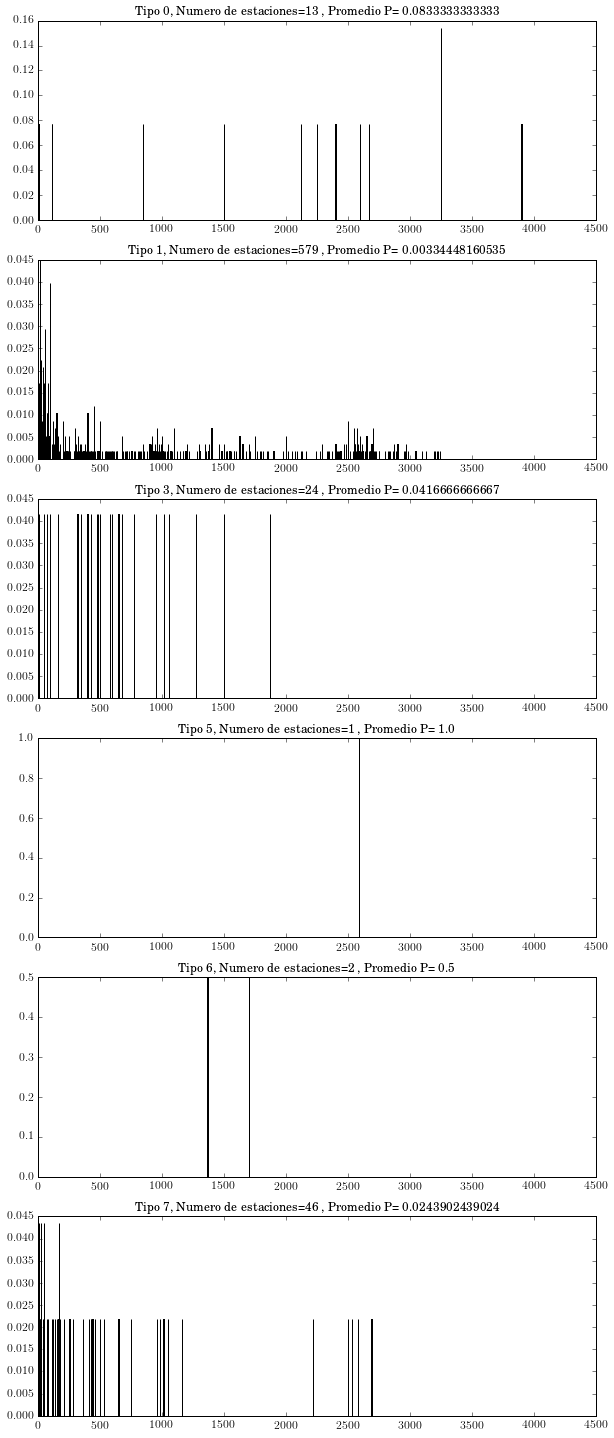

In [192]:
# Aquí estimamos la pdf discreta para las alturas -> P(h|CnAnTi)
# Creo que se puede hacer continua para la 0 y la 1, pero puede ser mejor simplemente dejar bins de 10 metros y ya
plt.figure(figsize=(10,25))
kk=0
paltmax=np.zeros(8)
proh=np.zeros((4099,8))
for k in np.unique(tipoest[critfilter]).astype(int):
    kk+=1
    plt.subplot(len(np.unique(tipoest[critfilter])), 1, kk)
    aux1,aux2,aux3=plt.hist(EST[critfilter][tipoest[critfilter]==k][:,4],bins=range(0,4100,1),normed=True)
    proh[:,k]=aux1
    plt.title("Tipo %i, Numero de estaciones=%s , Promedio P= %s" % (k,(tipoest[critfilter]==k).sum(),aux1[aux1!=0].mean()))
    paltmax[k]=aux1[aux1!=0].mean()

In [242]:
# Author: Jake VanderPlas
# License: BSD
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
def altprob(alt,filter):
    from astroML.plotting import setup_text_plots
    setup_text_plots(fontsize=12, usetex=True)
    altmin=0
    X = alt[filter][:, np.newaxis]
    #------------------------------------------------------------
    # Learn the best-fit GMM models
    #  Here we'll use GMM in the standard way: the fit() method
    #  uses an Expectation-Maximization approach to find the best
    #  mixture of Gaussians for the data
    # fit models with 1-11 components
    N = np.arange(1, 12)
    models = [None for i in range(len(N))]

    for i in range(len(N)):
        models[i] = GMM(N[i]).fit(X)

    # compute the AIC and the BIC
    AIC = [m.aic(X) for m in models]
    BIC = [m.bic(X) for m in models]

    #------------------------------------------------------------
    # Plot the results

    fig = plt.figure(figsize=(10, 4))
    fig.subplots_adjust(left=0.12, right=0.97,
                        bottom=0.21, top=0.9, wspace=0.5)


    # plot 1: data + best-fit mixture
    ax = fig.add_subplot(121)
    M_best = models[np.argmin(AIC)]

    x = np.linspace(altmin,4098 , 4099)
    logprob, responsibilities = M_best.score_samples(x.reshape((-1,1)))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]


    ax.hist(X, normed=True, histtype='stepfilled', alpha=0.4,bins=range(0,4500,50))
    ax.plot(x, pdf, '-k')
    ax.plot(x, pdf_individual, '--k')
    ax.text(0.04, 0.96, "Best-fit Mixture",
            ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    ax.set_xlim([0,4500])
    ax.set_ylim([0,0.0016])

    # plot 2: AIC and BIC
    ax = fig.add_subplot(122)
    ax.plot(N, AIC, '-k', label='AIC')
    ax.plot(N, BIC, '--k', label='BIC')
    ax.set_xlabel('n. components')
    ax.set_ylabel('information criterion')
    ax.legend(loc=2)
    plt.show()
    return pdf

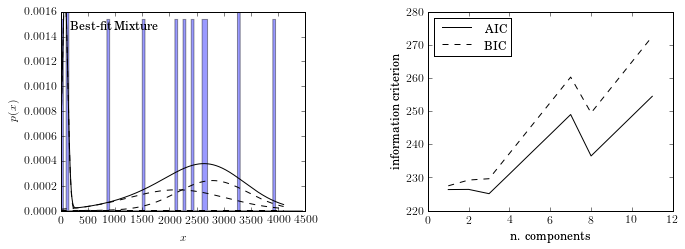

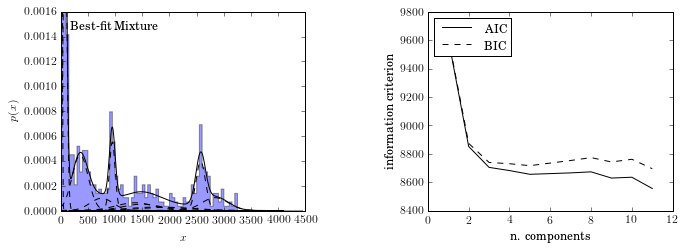

In [247]:
proh[:,0]=altprob(listam[:,4],listam[:,0]==0)
proh[:,1]=altprob(listam[:,4],listam[:,0]==1)

In [230]:
# Calculamos P(h|CnAnTi) y P(CnAnTi) por distintos métodos
# P(Ti) se puede calcular contando estaciones (D, dependiente) = P(MLnMDnMHnMB) 
# o contando los MX por aparte (I, independiente) = P(ML)P(MD)P(MH)P(MB)
# P(C|AnTi) se puede estimar por tabla de probabilidad (P), o como es descrito arriba (D), con las variables no medidas
paltura=np.zeros(len(EST))
pCnAnTi1=np.zeros(len(EST))
pCnAnTi2=np.zeros(len(EST))
pCnAnTi5=np.zeros(len(EST))
pCnAnTi6=np.zeros(len(EST))
for i in range(len(EST)):
    if(EST[i,4]<4099):
        paltura[i]=proh[EST[i,4].astype(int),tipoest[i].astype(int)]
    pCnAnTi1[i]=(pTiI*pAlTi*pClAnTiP)[tipoest[i].astype(int)]
    pCnAnTi2[i]=(pTiD*pAlTi*pClAnTiP)[tipoest[i].astype(int)]
    pCnAnTi5[i]=(pTiI*pAlTi*pClAnTiD)[tipoest[i].astype(int)]
    pCnAnTi6[i]=(pTiD*pAlTi*pClAnTiD)[tipoest[i].astype(int)]

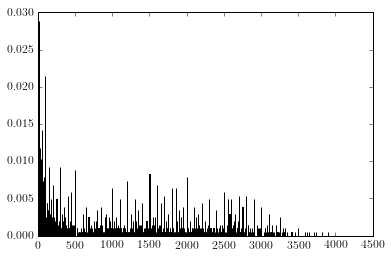

In [231]:
# Calculamos P(h)
prohabs,b,c=plt.hist(EST[:,4],normed=True,bins=range(0,4150,1))

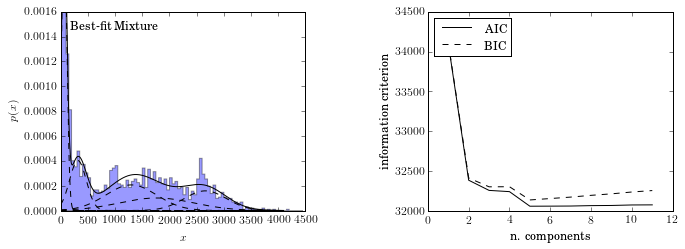

In [248]:
filter=np.isfinite(EST[:,4])
prohabs=altprob(EST[:,4],filter)

In [249]:
# Asignamos P(h) a cada estación
palturaabs=np.zeros(len(EST))
for i in range(len(EST)):
    if(EST[i,4]<4099):
        palturaabs[i]=prohabs[EST[i,4].astype(int)]

In [250]:
# P(CnAnTi|h)
# 1 = pt-I pclanti-P
# 2 = pt-D pclanti-P
# 3 = pt-I pclanti-I
# 4 = pt-D pclanti-I
pro1=pCnAnTi1*paltura/palturaabs
pro2=pCnAnTi2*paltura/palturaabs
pro5=pCnAnTi5*paltura/palturaabs
pro6=pCnAnTi6*paltura/palturaabs

(0.6, 10.6)

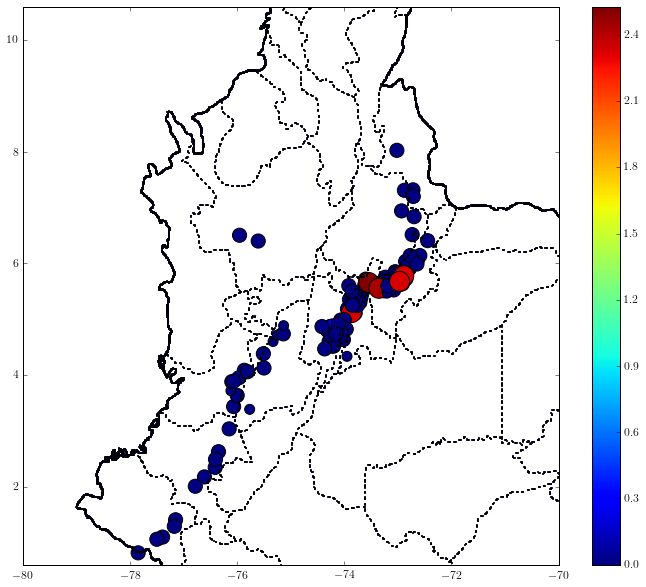

In [251]:
# hay que hacer 6 de estas, parece que la 6 funciona bien
plt.figure(figsize=(12,10))
filter=EST[:,4][critfilter]>2000
plt.scatter(-EST[:,2][critfilter][filter],-EST[:,3][critfilter][filter],c=pro6[critfilter][filter],s=100*EST[:,0][critfilter][filter])
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-80,-70)
plt.ylim(0.6,10.6)

In [252]:
# Aquí obtenemos nuestra lista maestra
# 0 = tipo estación
# 1 = código
# 2,3 = lonlat
# 4 = altura
# 5 = probabilidad
listam=np.hstack((tipoest[:, np.newaxis],EST[:,1:],pro6[:, np.newaxis]))[critfilter]

In [253]:
# filtramos por alturas
filter=listam[:,4]>2000
listacorta=listam[filter]

In [256]:
# generación de lista expandida que incluye pesos enteros para cada estación
probarr=np.around(listacorta[:,5]/listacorta[:,5].min(),0)
lendata=(probarr).sum().astype(int)
print "Tamaño de la lista expandida =", lendata
wdata=(probarr).astype(int)
listaexp=np.zeros((lendata,listacorta.shape[1]))
kcount=0
for i in range(len(probarr)):        
    for kinx in range(wdata[i]):
        listaexp[kinx+kcount,:]=listacorta[i,:]
    kcount=kcount+kinx+1 

Tamaño de la lista expandida = 239657


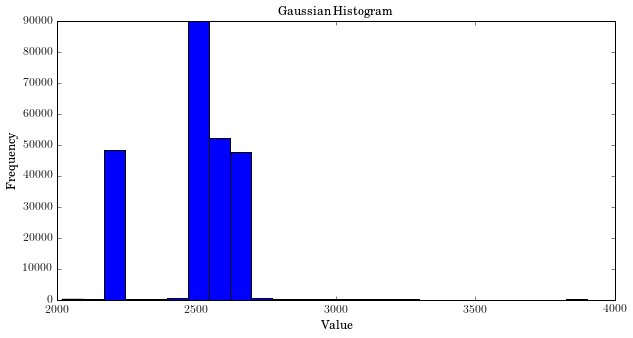

In [257]:
plt.figure(figsize=(10,5))
plt.hist(listaexp[:,4],bins=25)
plt.title("Gaussian Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")

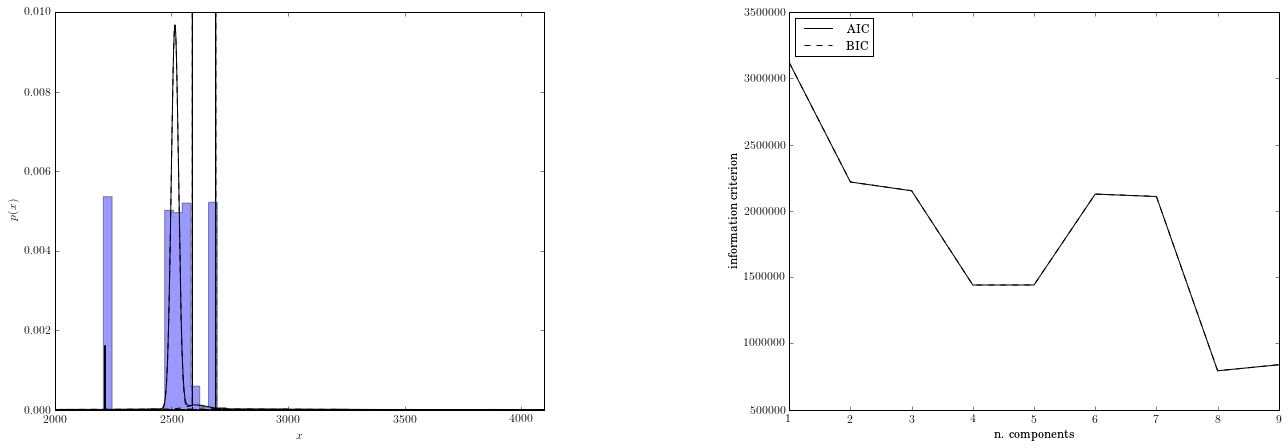

In [268]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

altmin=2000
altmax=4100
X = listaexp[:,4][(listaexp[:,4]>=altmin)*(listaexp[:,4]<=altmax)][:, np.newaxis]
N = np.arange(1, 10)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GMM(N[i]).fit(X)

AIC = [m.aic(X) for m in models]

BIC = [m.bic(X) for m in models]

fig = plt.figure(figsize=(20, 8))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


ax = fig.add_subplot(121)
M_best = models[np.argmin(AIC)]

x = np.linspace(altmin,altmax , altmax+1)
logprob, responsibilities = M_best.score_samples(x.reshape((-1,1)))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]


ax.hist(X, 50, normed=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
ax.set_xlim([altmin,altmax])
ax.set_ylim([0,0.01])
ax = fig.add_subplot(122)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)
plt.show()

In [269]:
cluster_label_alt=M_best.predict(X)[:, np.newaxis]
filter=(listaexp[:,4]>=altmin)*(listaexp[:,4]<=altmax)
listastacked=np.hstack((listaexp[filter],cluster_label_alt))
np.savetxt('lisstck.txt',listastacked)

In [270]:
listastacked.shape

(239657, 7)

In [271]:
cluster_label_alt.shape

(239657, 1)

In [272]:
listaexp.shape

(239657, 6)

In [273]:
np.unique(cluster_label_alt)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [274]:
%%bash
uniq -c lisstck.txt > listcomp.txt
rm lisstck.txt

<matplotlib.colorbar.Colorbar instance at 0x7fd8e93301b8>

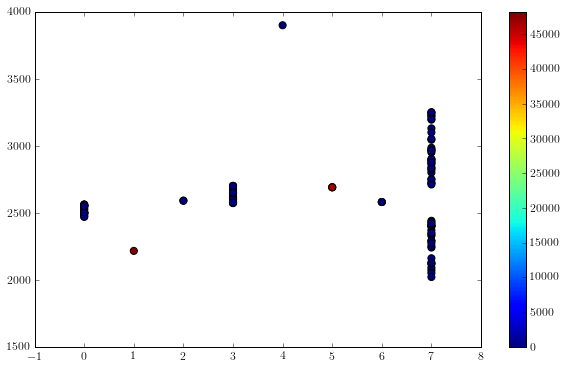

In [295]:
# distribución de grupos vs. altura vs. pesos estadísticos
listcomp=np.loadtxt('listcomp.txt')
plt.figure(figsize=(10,6))
plt.scatter(listcomp[:,7],listcomp[:,5],s=50,c=listcomp[:,0])
plt.colorbar()

(0, 10)

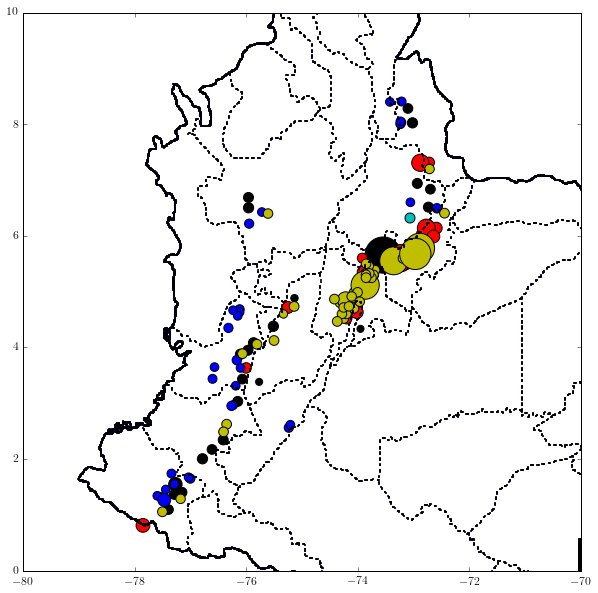

In [361]:
plt.figure(figsize=(10,10))
filter=(listcomp[:,6]==0)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='k',s=listcomp[:,0][filter]*5)
filter=(listcomp[:,6]==1)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='r',s=listcomp[:,0][filter]*5)
filter=(listcomp[:,6]==2)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='b',s=listcomp[:,0][filter]*5)
filter=(listcomp[:,6]==3)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='y',s=listcomp[:,0][filter]*5)
filter=(listcomp[:,6]==4)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='g',s=listcomp[:,0][filter]*5)
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.scatter(np.array([-73.06]),np.array([6.3211484]),s=100,c='c')
#plt.colorbar()
plt.xlim(-80,-70)
plt.ylim(0,10)

(0, 10)

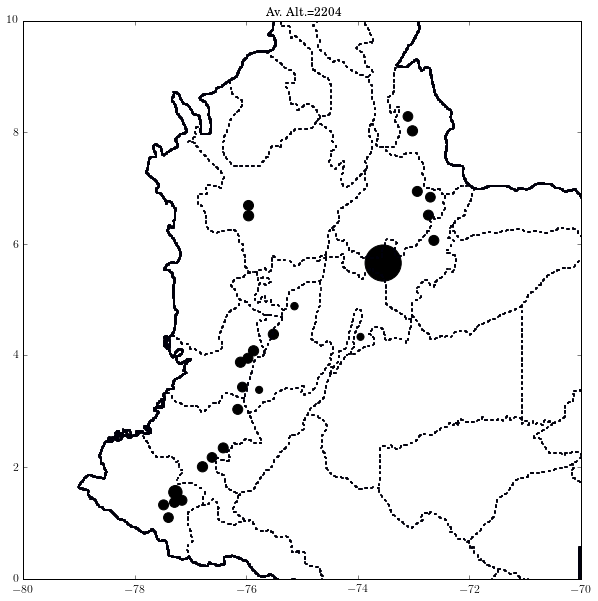

In [336]:
plt.figure(figsize=(10,10))

filter=(listcomp[:,6]==0)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='k',s=listcomp[:,0][filter]*5)

plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.title('Av. Alt.=%i' % listcomp[:,5][filter].mean())

#plt.colorbar()
plt.xlim(-80,-70)
plt.ylim(0,10)

(0, 10)

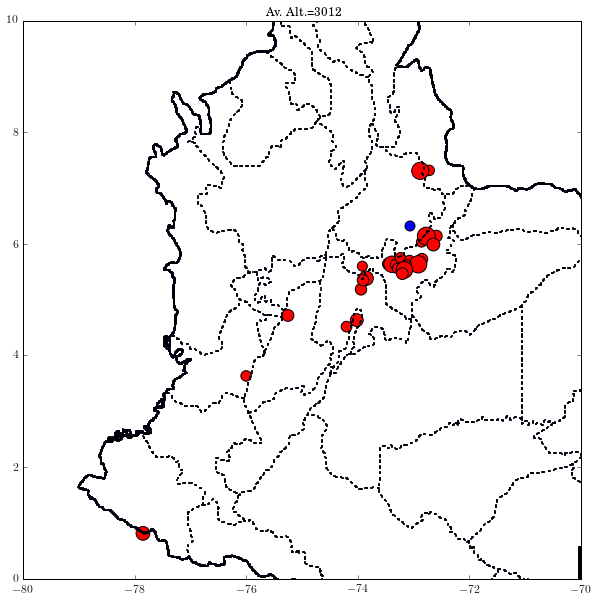

In [359]:
plt.figure(figsize=(10,10))

filter=(listcomp[:,6]==1)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='r',s=listcomp[:,0][filter]*5)
plt.scatter(np.array([-73.06]),np.array([6.3211484]),s=100,c='b')
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.title('Av. Alt.=%i' % listcomp[:,5][filter].mean())

#plt.colorbar()
plt.xlim(-80,-70)
plt.ylim(0,10)

(0, 10)

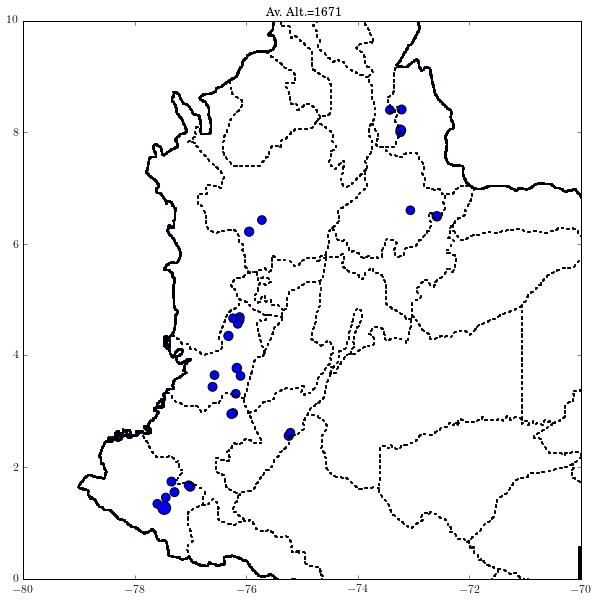

In [339]:
plt.figure(figsize=(10,10))

filter=(listcomp[:,6]==2)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='b',s=listcomp[:,0][filter]*5)

plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.title('Av. Alt.=%i' % listcomp[:,5][filter].mean())

#plt.colorbar()
plt.xlim(-80,-70)
plt.ylim(0,10)

(0, 10)

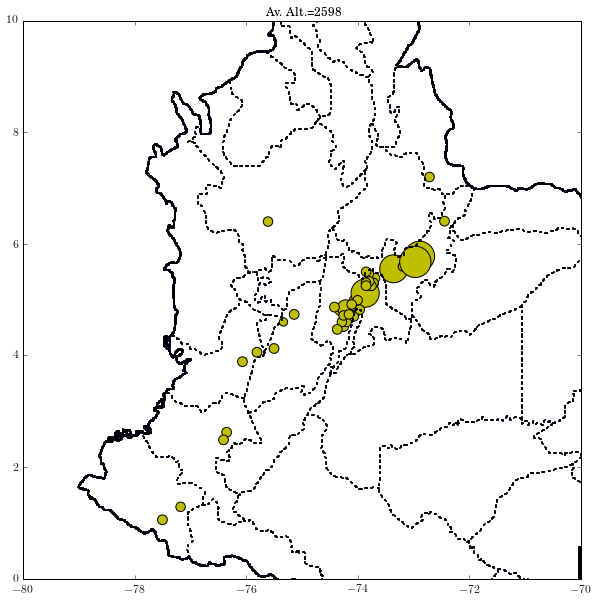

In [363]:
plt.figure(figsize=(10,10))

filter=(listcomp[:,6]==3)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='y',s=listcomp[:,0][filter]*5)

plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.title('Av. Alt.=%i' % listcomp[:,5][filter].mean())

#plt.colorbar()
plt.xlim(-80,-70)
plt.ylim(0,10)

In [ ]:
# esqueleto de clusters climatológicos por variable por cluster de alturas, hay que modificarlo (quitar lo que dice 12sc)
# clusters favoritos (encima de 2500 metros) son 
# clusters de lluvia: 
plt.figure(figsize=(12,10))
filter=(listcomp12sc[:,6]==2)
list12label=np.zeros(len(listcomp12sc[filter]))+11
for i in range(len(listcomp12sc[filter])):
    if((codeL==listcomp12sc[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelL[codeL==listcomp12sc[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title("Precipitation clusters")

# Desde aqui

In [238]:
# Alex Amaral-Rogers' Gaussian Kernel Contour generator
#returns the co-added gaussian kernels grid, and an array of numbers equaling the levels corresponding to the input sigma array.

#the inputs to the function is
#x = array of x data
#y = array of y data (must be the same size as x)
#x1,x2, y1,y2 the limits of the region in which you wish the plot to be.
#N the number of grid points in the axis. You can change this to be Nx, Ny if you preferred.
#sig = list of contour levels you want to plot in terms of sigma levels i.e. [0.5, 1, 2.0] is 0.5 sigma, 1 sigma, 2 sigma levels.


from scipy.stats import gaussian_kde
from scipy.special import erf

def CONTOURP(x, x1, x2, y, y1, y2, N, sig):
    xx = np.linspace(x1, x2, N)
    yy = np.linspace(y1, y2, N)

    XX, YY = np.meshgrid(xx, yy)
    values = np.vstack([x, y])
    positions = np.vstack([XX.ravel(), YY.ravel()])
    kernel = gaussian_kde(values)
    f = np.reshape(kernel(positions).T, XX.shape)

    PCT = 1.0 - np.cumsum(np.sort(f.ravel()))/np.sum(f)
    NN = np.sort(f.ravel())
    SO = [ ]
    for s in sig:
        SO += [NN[(np.abs(PCT - erf(s/np.sqrt(2.0)))).argmin()]]

    return f, SO

In [239]:
# Obtenemos los datos para hacer el contorno de densidad de datos
lnmin=-85
lnmax=-65
ltmin=-5
ltmax=14
nmesh=200
sigarray=[1.,2.]
CONT=CONTOURP(-EST[:,2],lnmin,lnmax,-EST[:,3],ltmin,ltmax,nmesh,sigarray);
xmesh=np.linspace(lnmin,lnmax,nmesh)
ymesh=np.linspace(ltmin,ltmax,nmesh)
Xmesh,Ymesh=np.meshgrid(xmesh,ymesh)

(-5, 14)

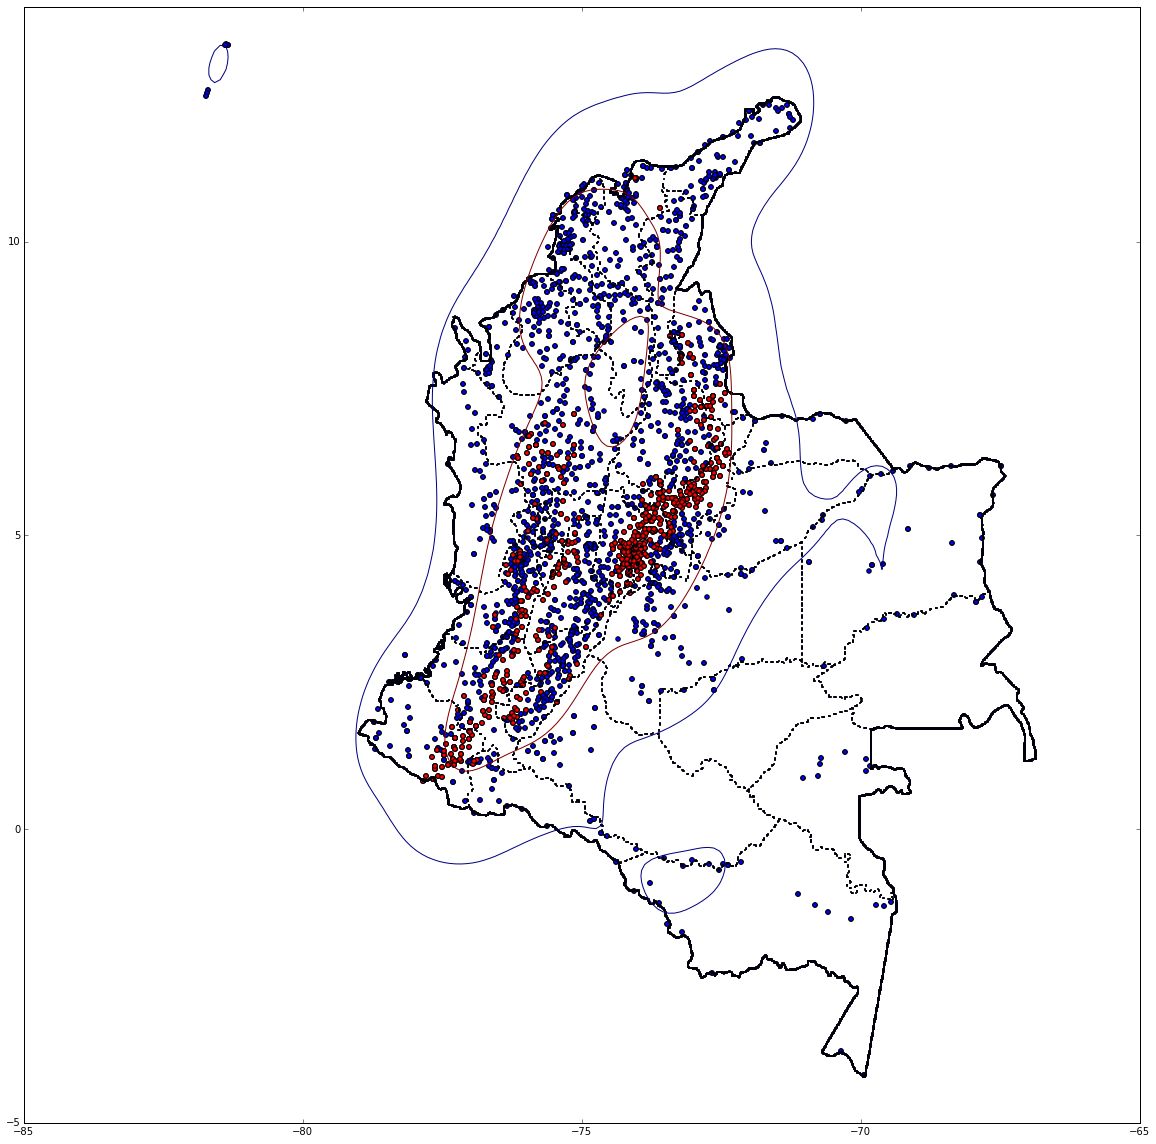

In [244]:
# contornos + azules= todas las estaciones dentro de sigarray=1,2 sigma
# rojos = cumplen al menos una de nuestras condiciones
plt.figure(figsize=(20,20))
plt.contour(Xmesh,Ymesh,CONT[0], levels = CONT[1])
plt.scatter(-LonT, -LatT)
plt.scatter(-DATT[:,1],-DATT[:,2],c='r')
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-85,-65)
plt.ylim(-5,14)

In [833]:
# Obtenemos los datos para hacer el contorno de densidad de datos
lnmin=-85
lnmax=-65
ltmin=-5
ltmax=14
nmesh=200
sigarray=[1.,2.]
filter=(EST[:,0]==4)
CONT=CONTOURP(-EST[:,2][filter],lnmin,lnmax,-EST[:,3][filter],ltmin,ltmax,nmesh,sigarray);
xmesh=np.linspace(lnmin,lnmax,nmesh)
ymesh=np.linspace(ltmin,ltmax,nmesh)
Xmesh,Ymesh=np.meshgrid(xmesh,ymesh)

(-5, 14)

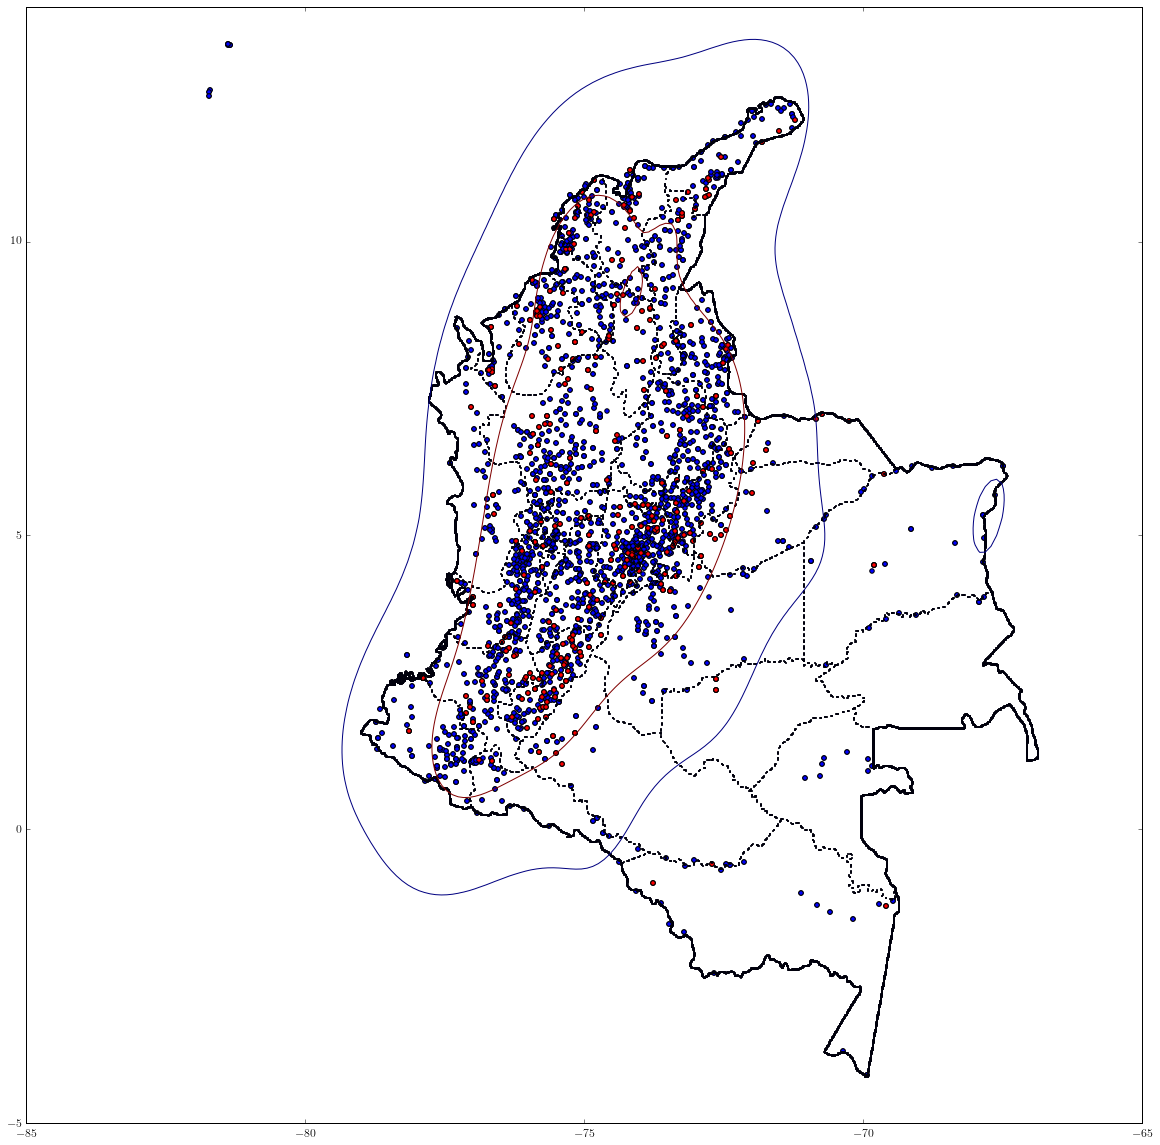

In [838]:
# contornos + azules= todas las estaciones dentro de sigarray=1,2 sigma
# rojos = cumplen al menos una de nuestras condiciones
plt.figure(figsize=(20,20))
plt.contour(Xmesh,Ymesh,CONT[0], levels = CONT[1])
plt.scatter(-LonT, -LatT)
plt.scatter(-LonT[filter], -LatT[filter],c='r')
#plt.scatter(-DATT[:,1],-DATT[:,2],c='r')
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-85,-65)
plt.ylim(-5,14)

In [840]:
for i in range(5):
    print (EST[:,0]==i).sum()

0
29
1565
138
314


In [843]:
EST[:,2].shape

(2046,)

In [844]:
LonT.shape

(4829,)